파일 위치: 한국어 SNS 데이터셋은 압축을 풀고 json 파일을 '/content/drive/MyDrive/chatbot' 안에 넣고 시작합니다. 데이터 사이즈가 크기 때문에 전처리는 TPU 고용량 RAM 런타임으로 시행하였습니다. (딱히 TPU를 쓴 건 아니지만 RAM이 자꾸 터져서 35GB의 RAM을 확보하려고)

## Aihub의 한국어 SNS 데이터셋

### 1. 전처리
  
    * 오타와 띄어쓰기 문제가 심각해서 네이버 맞춤법 검사기 사용함 (근데 여기에 형태소 분석기도 써야할지는 모르겠음)
    * 유아틱한 말투도 있던데 이런식으로 말해도 될지..나이를 필터링해서 30대 이상만 사용할 수도 있을 것 같음 

### 2. 데이터셋 가공
    * 발화가 나뉘어져 있어도 같은 턴이면 하나의 발화로 합쳤음
      ex) p1 : 아니 // p1 : 나도 몰라 -> p1 : 아니 나도 몰라
    * 화자가 두 명인 데이터셋만 추렸음
    * 현재 작은 샘플 데이터만으로 훈련했으며, 추후 분야별로 몇 개씩 뽑아서 사용하면 좋을 것 같음 
    (분야: 개인및관계, 미용과건강, 상거래(쇼핑), 시사교육, 식음료, 여가생활, 일과직업, 주거와생활, 행사)

### 3. 네거티브 샘플링 고민
      (내가 찾은 Poly encoder 코드에서 예시 데이터로 DSTC7가 주어져 있어서 여기를 많이 참고함)
    * DSTC7 Task1(Ubuntu IRC 가공한 것) [논문](http://workshop.colips.org/dstc7/papers/dstc7_task1_final_report.pdf)을 읽어보니까 아예 데이터셋을 train, dev, test, candidate로 4등분해서, candidate에서만 네거티브 문장을 뽑아서 쓴 것 같음
    * DSTC7 Task1 train은 500개, dev는 100개, test는 100개, candidate는 115개의 dialogue로 이루어져 있음. 그리고 한 context 당 1개의 positive 샘플과 99개의 negative 샘플로 이루어져 있음.
    * Recipes for building an open-domain chatbot 논문에서는 배치의 다른 response를 negative로 사용했다고 하며, 배치사이즈 512

-> 일단 배치 사이즈를 32로 잡고, context 하나 당 response 100개의 txt 파일 만듦

## 사용한 BERT 모델
    * SKT koBERT https://huggingface.co/skt/kobert-base-v1/tree/main
    * monologg https://huggingface.co/monologg/kobert-lm/tree/226c1548574cc3aa709ff0f5c9b2152b5bc284cd
## Poly encoder 코드 수정
    * inference 코드 추가

## 추후 과제
    * 비식별화 태그 처리 -> 데이터 전처리 부터 (필터링) 나중에 출력될 값 정하는 것까지
      ex) #@시스템#사진#, #@이모티콘#
    * 라이브러리 버전 통일 후 코드 작동하는지 확인
    * 파트별 BERT 모델 통일?? 만약에 통일하면 vocab이 동일하니까, 임베딩 벡터 형태로 받을 수 있어서 더 빠를듯 
    

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Thu Sep 23 10:11:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import os
import argparse
import random
import json
import zipfile
import collections
import copy
import re
import shutil
from tqdm.notebook import tqdm, trange

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
!python  #3.7.11

In [ ]:
!pip show requests #2.23.0

### 전처리 프로세스

1. 맞춤법 교정 : 네이버 맞춤법 검사기
2. 형태소 분리 : khaiii

맞춤법 검사기 및 Khaiii 실습

In [ ]:
#https://ssung-22.tistory.com/49
import json
import urllib
from bs4 import BeautifulSoup

def spellchecker(q):

    params = urllib.parse.urlencode({
        "_callback": "",
        "q": q
    })
    
    # 네이버 맞춤법 검사기 사용하여 문법 교정 
    data = urllib.request.urlopen("https://m.search.naver.com/p/csearch/ocontent/spellchecker.nhn?" + params)
    data = data.read().decode("utf-8")[1:-2]
    data = json.loads(data)
    data = data["message"]["result"]["html"]
    data = BeautifulSoup(data, "html.parser").getText()
    
    return data

In [ ]:
spellchecker('ㅋㅋㅋㅋㅋㅋㅋ아니얌 날도더운데 집으로가서 쉬어,')

'ᄏᄏᄏᄏᄏᄏᄏ 아니야 날도 더운데 집으로 가서 쉬어,'

띄어쓰기는 잘 고쳐주지만 단어를 이상하게 바꾸는 경우가 많다

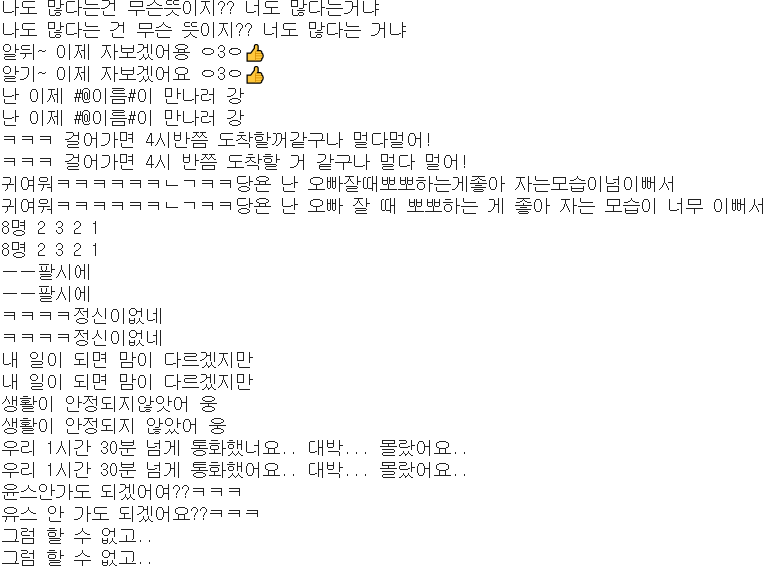

In [ ]:
#from hanspell import spell_checker
#result = spell_checker.check(u'안녕 하세요. 저는 한국인 입니다. 이문장은 한글로 작성됬습니다.')
#result.as_dict()  # dict로 출력

In [ ]:
cd ..

/content


In [6]:
!git clone https://github.com/kakao/khaiii.git
#https://banana-media-lab.tistory.com/entry/colab%EC%97%90%EC%84%9C-khaiii-%ED%98%95%EB%B6%84%EC%84%9D%EA%B8%B0-%EC%84%A4%EC%B9%98%ED%95%B4%EC%84%9C-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0

Cloning into 'khaiii'...
remote: Enumerating objects: 1016, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 1016 (delta 46), reused 76 (delta 29), pack-reused 877
Receiving objects: 100% (1016/1016), 33.06 MiB | 38.26 MiB/s, done.
Resolving deltas: 100% (404/404), done.


In [7]:
!pip install cmake

In [8]:
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all


-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Performing Test fma_compiles
-- Performing Test fma_compiles - Success
-- Performing Test fma_runs
-- Performing Test fma_runs - Success
-- [khaiii] fused multiply add option enab

In [9]:
!cd /content/build/ && make resource
!cd /content/build/ && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

Scanning dependencies of target resource
INFO:root:config: {
    "cutoff": 1,
    "embed_dim": 35,
    "hidden_dim": 320,
    "model_id": "munjong.cut1.win4.sdo0.1.emb35.lr0.001.lrd0.9.bs500",
    "rsc_src": "../rsc/src",
    "window": 4
}
INFO:root:vocab.in: 5621 entries, 0 cutoff
INFO:root:vocab.out: 500 entries, 0 cutoff
INFO:root:restore.dic: 4303 entries
INFO:root:preanal.manual
INFO:root:preanal.auto
INFO:root:trie saved: /content/build/share/khaiii/preanal.tri
INFO:root:total nodes: 120812
INFO:root:expected size: 1932992
INFO:root:value saved: /content/build/share/khaiii/preanal.val
INFO:root:total entries: 83373
INFO:root:expected size: 593730
INFO:root:restore.key: 17212
INFO:root:restore.val: 68848
INFO:root:restore.one: 503
INFO:root:base.errpatch.manual
INFO:root:base.errpatch.auto
INFO:root:trie saved: /content/build/share/khaiii/errpatch.tri
INFO:root:total nodes: 2067
INFO:root:expected size: 33072
INFO:root:length saved: /content/build/share/khaiii/errpatch.len
INFO:ro

In [10]:
from khaiii import KhaiiiApi
api = KhaiiiApi()
for word in api.analyze('안녕, 세상.'):
    print(word)

안녕,	안녕/IC + ,/SP
세상.	세상/NNG + ./SF


In [ ]:
sentence = '오늘은 조금 늦게 나왔어요.'
for word in api.analyze(sentence):
  for morph in word.morphs:
    print(morph.lex, end= " ")
    

오늘 은 조금 늦 게 나오 았 어요 . 

In [ ]:
sentence = 'ㅋㅋㅋㅋㅋㅋㅋ아니양 날도더운데 집으로가서 쉬어,'
for word in api.analyze(sentence):
  for morph in word.morphs:
    print(morph.lex, end= " ")

ㅋㅋㅋㅋㅋ ㅋ ㅋ 아 니양 날도 덥 ㄴ데 집 으로 가 아서 쉬 어 , 

In [ ]:
#data_dir = "/content/drive/MyDrive/chatbot/한국어 SNS/Training/[라벨]한국어SNS_train.zip"

In [ ]:
#cd /content/drive/MyDrive/chatbot/한국어 SNS/Training

/content/drive/MyDrive/chatbot/한국어 SNS/Training


In [ ]:
#!unzip [라벨]한국어SNS_train.zip

Archive:  [라벨]한국어SNS_train.zip
  inflating: 개인및관계.json    
  inflating: 미용과건강.json    
  inflating: 상거래(쇼핑).json  
  inflating: 시사교육.json       
  inflating: 식음료.json          
  inflating: 여가생활.json       
  inflating: 일과직업.json       
  inflating: 주거와생활.json    
  inflating: 행사.json             


In [ ]:
#테스트 파일
#sample_dir = "/content/drive/MyDrive/chatbot"

In [ ]:
#!unzip 2020-02-024.한국어SNS_sample.zip

Archive:  2020-02-024.한국어SNS_sample.zip
  inflating: sample.json             


In [30]:
cd /content/drive/MyDrive/chatbot

/content/drive/MyDrive/chatbot


In [4]:
#임시 args 설정
args = {
    # random seed value
    "seed": 123
}
args = argparse.Namespace(**args)

# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

데이터 형태


In [ ]:
with open("j.json") as f:
    c = json.load(f)
    for i, line in enumerate(c['data']):
        print(line)
        if i > 20:
            break

{'header': {'dialogueInfo': {'numberOfParticipants': 2, 'numberOfUtterances': 18, 'numberOfTurns': 8, 'type': '일상 대화', 'topic': '개인 및 관계', 'dialogueID': 'b7d3e9ea-8b8d-596a-8abe-7dedd3ea565c'}, 'participantsInfo': [{'age': '20대', 'residentialProvince': '서울특별시', 'gender': '남성', 'participantID': 'P01'}, {'age': '20대', 'residentialProvince': '서울특별시', 'gender': '여성', 'participantID': 'P02'}]}, 'body': [{'utterance': '내일 볼까 나도', 'utteranceID': 'U1', 'participantID': 'P01', 'date': '2019-07-22', 'turnID': 'T1', 'time': '01:05:00'}, {'utterance': '그친구랑', 'utteranceID': 'U2', 'participantID': 'P01', 'date': '2019-07-22', 'turnID': 'T1', 'time': '01:05:00'}, {'utterance': '여자야?', 'utteranceID': 'U3', 'participantID': 'P02', 'date': '2019-07-22', 'turnID': 'T2', 'time': '01:05:00'}, {'utterance': '아 여자안된댔지 ㅋㅋㅋㅋㅋㅋㅋ', 'utteranceID': 'U4', 'participantID': 'P01', 'date': '2019-07-22', 'turnID': 'T3', 'time': '01:05:00'}, {'utterance': '쏴뤼~', 'utteranceID': 'U5', 'participantID': 'P01', 'date': '201

In [ ]:
{
  "numberOfItems": 14990,
  "data": [
    {
      "header": {
        "dialogueInfo": {
          "numberOfParticipants": 2,
          "numberOfUtterances": 18,
          "numberOfTurns": 8,
          "type": "일상 대화",
          "topic": "개인 및 관계",
          "dialogueID": "b7d3e9ea-8b8d-596a-8abe-7dedd3ea565c"
        },
        "participantsInfo": [
          {
            "age": "20대",
            "residentialProvince": "서울특별시",
            "gender": "남성",
            "participantID": "P01"
          },
          {
            "age": "20대",
            "residentialProvince": "서울특별시",
            "gender": "여성",
            "participantID": "P02"
          }
        ]
      },
      "body": [
        {
          "utterance": "내일 볼까 나도",
          "utteranceID": "U1",
          "participantID": "P01",
          "date": "2019-07-22",
          "turnID": "T1",
          "time": "01:05:00"
        },
        {
          "utterance": "그친구랑",
          "utteranceID": "U2",
          "participantID": "P01",
          "date": "2019-07-22",
          "turnID": "T1",
          "time": "01:05:00"
        }]}}

In [ ]:
print(len(c)) #2 -> numberofItems, data
print(len(c['data']))

2
14990


Sample말고 전체 데이터 사용

In [32]:
data_dir = "/content/drive/MyDrive/chatbot/한국어 SNS/Training"

In [33]:
chatbot_dir = "/content/drive/MyDrive/chatbot"

3명 이상 나누는 대화들도 있기 때문에 2명만 나누는 대화들만 뽑았음

In [15]:
def filter_two_participants_dialogues(json_path):
    cnt = 0
    new_json = {
      "data": []}

    with open(json_path) as f:
      c = json.load(f, strict=False)
      for i, line in enumerate(c['data']):
        #print(line)
        num_of_p = line['header']['dialogueInfo']['numberOfParticipants']
        if num_of_p == 2:
          new_json['data'].append(line)
          cnt += 1

    new_json['numberOfItems'] = cnt
    return new_json
                                      

In [16]:
def write_json_file(file_name, data):
    with open('{}.json'.format(file_name), 'w', encoding='UTF-8') as file:
        file.write(json.dumps(data, ensure_ascii=False))

In [ ]:
cnt = 0
with open(os.path.join(data_dir,'개인및관계.json')) as f:
    c = json.load(f,strict=False)
    for i, line in enumerate(c['data']):
      cnt += 1
print(cnt)

356880


In [ ]:
#화자가 2명 대화만 자르기 전 원본 데이터의 대화 개수
cnt = 0
with open(os.path.join(data_dir, "개인및관계.json")) as f:
  c = json.load(f, strict=False)
  for i, line in enumerate(c['data']):
    cnt += 1
print(cnt)

In [ ]:
new_json = filter_two_participants_dialogues(os.path.join(data_dir,'개인및관계.json'))
write_json_file('person_relation', new_json)
#with open('j.json', 'w', encoding='UTF-8') as file:
#     file.write(json.dumps(new_json, ensure_ascii=False))

In [19]:
pwd

'/content/drive/MyDrive/chatbot'

In [ ]:
cnt = 0
with open('person_relation.json') as f:
    c = json.load(f,strict=False)
    for i, line in enumerate(c['data']):
      print(line)
      if i > 100:
        break

{'header': {'dialogueInfo': {'numberOfParticipants': 2, 'numberOfUtterances': 11, 'numberOfTurns': 4, 'type': '일상 대화', 'topic': '개인 및 관계', 'dialogueID': '12bdfe81-8659-59c7-96ec-1c91d99655a7'}, 'participantsInfo': [{'age': '20대', 'residentialProvince': '서울특별시', 'gender': '여성', 'participantID': 'P01'}, {'age': '20대', 'residentialProvince': '서울특별시', 'gender': '여성', 'participantID': 'P02'}]}, 'body': [{'utterance': '푹자요 우리애기', 'utteranceID': 'U1', 'participantID': 'P01', 'date': '2020-04-07', 'turnID': 'T1', 'time': '00:42:00'}, {'utterance': '야보랑 카토가햐아하은데', 'utteranceID': 'U2', 'participantID': 'P02', 'date': '2020-04-07', 'turnID': 'T2', 'time': '00:43:00'}, {'utterance': '미안해여ㅠㅠㅜㅜㅜ', 'utteranceID': 'U3', 'participantID': 'P02', 'date': '2020-04-07', 'turnID': 'T2', 'time': '00:43:00'}, {'utterance': '언니랑 카톡하다버니 사랑이너무 가특해서', 'utteranceID': 'U4', 'participantID': 'P02', 'date': '2020-04-07', 'turnID': 'T2', 'time': '00:43:00'}, {'utterance': '마구잠이 스르륵호는거있지', 'utteranceID': 'U5', 'partici

In [ ]:
shutil.copy('person_relation.json', os.path.join(chatbot_dir,'2person.json'))

'/content/drive/MyDrive/chatbot/2person.json'

In [20]:
#화자가 2명인 대화 개수
cnt = 0
with open('2person.json') as f:
    c = json.load(f,strict=False)
    for i, line in enumerate(c['data']):
      cnt += 1
print(cnt)

321556


2명이서 나눈 대화만 추렸기에 356880에서 321556개로 데이터 개수가 줄었습니다.

데이터셋을 train, dev, test로 분리

In [ ]:
def split_dataset(json_path):
    """데이터셋을 train, dev, test로 나누는 함수"""

    with open(json_path) as f:
        c = json.load(f, strict=False)
        total_count = c['numberOfItems']
        train_num = int(total_count * 0.6)
        dev_num = int(total_count * 0.2)
        test_num = int(total_count * 0.2)
      
        
        if train_num + dev_num + test_num  != total_count:
            train_num += total_count - (train_num + dev_num + test_num )

        assert train_num + dev_num + test_num  == total_count
        print(train_num, dev_num, test_num)
        train = {'data': []}
        dev = {'data': []}
        test = {'data': []}

      
        train['data'] = c['data'][:train_num]
        dev['data'] = c['data'][train_num:train_num+dev_num]  
        test['data'] = c['data'][train_num+dev_num:]
      

        train['numberOfItems'] = len(train['data'])
        dev['numberOfItems'] = len(dev['data'])
        test['numberOfItems'] = len(test['data'])
    return train, dev, test

In [ ]:
train, dev, test = split_dataset('2person.json')

192934 64311 64311


파일 별로 json형식으로 저장

In [ ]:
write_json_file("p_train",train)
write_json_file("p_dev", dev)
write_json_file("p_test", test)

In [ ]:
#json파일이 제대로 만들어졌는지 확인

with open("p_train.json") as f:
  c = json.load(f)
  for i, line in enumerate(c['data']):
    print(line)
    if i > 10:
      break


{'header': {'dialogueInfo': {'numberOfParticipants': 2, 'numberOfUtterances': 11, 'numberOfTurns': 4, 'type': '일상 대화', 'topic': '개인 및 관계', 'dialogueID': '12bdfe81-8659-59c7-96ec-1c91d99655a7'}, 'participantsInfo': [{'age': '20대', 'residentialProvince': '서울특별시', 'gender': '여성', 'participantID': 'P01'}, {'age': '20대', 'residentialProvince': '서울특별시', 'gender': '여성', 'participantID': 'P02'}]}, 'body': [{'utterance': '푹자요 우리애기', 'utteranceID': 'U1', 'participantID': 'P01', 'date': '2020-04-07', 'turnID': 'T1', 'time': '00:42:00'}, {'utterance': '야보랑 카토가햐아하은데', 'utteranceID': 'U2', 'participantID': 'P02', 'date': '2020-04-07', 'turnID': 'T2', 'time': '00:43:00'}, {'utterance': '미안해여ㅠㅠㅜㅜㅜ', 'utteranceID': 'U3', 'participantID': 'P02', 'date': '2020-04-07', 'turnID': 'T2', 'time': '00:43:00'}, {'utterance': '언니랑 카톡하다버니 사랑이너무 가특해서', 'utteranceID': 'U4', 'participantID': 'P02', 'date': '2020-04-07', 'turnID': 'T2', 'time': '00:43:00'}, {'utterance': '마구잠이 스르륵호는거있지', 'utteranceID': 'U5', 'partici

In [21]:
from khaiii import KhaiiiApi
api = KhaiiiApi()
morphs_list = []
sentence = '오늘은 조금 늦게 나왔어요.'
for word in api.analyze(sentence):
  for morph in word.morphs:
    morphs_list.append(morph.lex)
print(morphs_list)
    #print(morph.lex, end= " ")

['오늘', '은', '조금', '늦', '게', '나오', '았', '어요', '.']


In [56]:
#형태소 분리해서 저장하기 #train
#20분을 지나고 있음...
#총 24분
import os
import json
with open(os.path.join(chatbot_dir,"p_train.json")) as f:
  c = json.load(f)
  for dialogue in c['data']:
      messages = dialogue['body']
      for i, utter in enumerate(messages):
          tmp_string = utter['utterance']
          morphs_list = []
          for word in api.analyze(tmp_string):
            for morph in word.morphs:
              morphs_list.append(morph.lex)
          utter['utterance'] = " ".join(morphs_list)

In [57]:
with open("morphs_train.json", "w") as jsonFile:
    json.dump(c, jsonFile)

In [ ]:
#형태소 분리해서 저장하기 #dev
#대략 10분 가까이 걸린 것 같음
import os
import json
with open(os.path.join(chatbot_dir,"p_dev.json")) as f:
  c = json.load(f)
  for dialogue in c['data']:
      messages = dialogue['body']
      for i, utter in enumerate(messages):
          tmp_string = utter['utterance']
          morphs_list = []
          for word in api.analyze(tmp_string):
            for morph in word.morphs:
              morphs_list.append(morph.lex)
          utter['utterance'] = " ".join(morphs_list)
        

In [ ]:
cnt = 0
for dialogue in c['data']:
    messages = dialogue['body']
    for i, utter in enumerate(messages):
      cnt += 1
      if i < 110:
        print(utter)
print(cnt)    

In [54]:
with open("morphs_dev.json", "w") as jsonFile:
    json.dump(c, jsonFile)

In [39]:
cnt = 0
with open(os.path.join(chatbot_dir,"p_dev.json")) as f:
  c = json.load(f)
  for dialogue in c['data']:
    cnt += 1
print(cnt) #dialogue가 64311개

64311


In [55]:
cnt = 0
with open(os.path.join(chatbot_dir,"morphs_dev.json")) as f:
  c = json.load(f)
  for dialogue in c['data']:
    cnt += 1
print(cnt) #dialogue가 64311개

64311


In [45]:
cnt = 0
for dialogue in c['data']:
  messages = dialogue['body']
  for i, utter in enumerate(messages):
    
    cnt += 1
print(cnt)
#utterance개 996151개

996151


In [38]:
morph_list = []
" ".join(morphs_list)

''

In [ ]:
#형태소 분리해서 저장하기 #test
import os
import json
with open(os.path.join(chatbot_dir,"p_test.json")) as f:
  t = json.load(f,encoding='utf-8')
  for dialogue in t['data']:
      messages = dialogue['body']
      for i, utter in enumerate(messages):
          tmp_string = utter['utterance']
          morphs_list = []
          for word in api.analyze(tmp_string):
            if word == "":  #결과가 없을 때 khaiii error 처리    if not results: --> 226             raise KhaiiiExcept(self._last_error())
              morphs_list = []
            for morph in word.morphs:
              morphs_list.append(morph.lex)
          utter['utterance'] = " ".join(morphs_list)


In [ ]:
with open("morphs_test.json", "w") as jsonFile:
    json.dump(t, jsonFile)

In [25]:
with open('p_dev.json') as f:
    c = json.load(f,strict=False)
    for i, line in enumerate(c['data']):
      print(line)
      if i > 10:
        break

{'header': {'dialogueInfo': {'numberOfParticipants': 2, 'numberOfUtterances': 14, 'numberOfTurns': 5, 'type': '일상 대화', 'topic': '개인 및 관계', 'dialogueID': '0fe62cbb-5cfa-5ef8-964c-a4fc11814bf7'}, 'participantsInfo': [{'age': '20대', 'residentialProvince': '경상남도', 'gender': '여성', 'participantID': 'P01'}, {'age': '20대', 'residentialProvince': '서울특별시', 'gender': '여성', 'participantID': 'P02'}]}, 'body': [{'utterance': '나 뷔 머리 반반 다른줄 몰랐음ㅋㅋ', 'utteranceID': 'U1', 'participantID': 'P01', 'date': '2018-08-23', 'turnID': 'T1', 'time': '11:05:00'}, {'utterance': '나도 근데 이거 동양 컨셉 아니라 한국임', 'utteranceID': 'U2', 'participantID': 'P02', 'date': '2018-08-23', 'turnID': 'T2', 'time': '11:07:00'}, {'utterance': '일본 새끼들이', 'utteranceID': 'U3', 'participantID': 'P02', 'date': '2018-08-23', 'turnID': 'T2', 'time': '11:07:00'}, {'utterance': '일본풍이라고 우겨서', 'utteranceID': 'U4', 'participantID': 'P02', 'date': '2018-08-23', 'turnID': 'T2', 'time': '11:07:00'}, {'utterance': '아미들 예민쓰', 'utteranceID': 'U5', 'partic

In [ ]:
#write_json_file("p_train",train)
#write_json_file("p_dev", dev)
#write_json_file("p_test", test)

Train, dev,test 최종 데이터셋 만들어서 txt 파일로 저장

Poly-encoder 코드에서 훈련에 사용한 dev.txt 파일 예시와 동일한 형식으로 만들려고 하였음. context 하나에 100개의 response

\<label> \t \<context> \t \<response>

In [ ]:
"""
dev.txt
1	  participant 1: hey guys, does your livecd have chroot installed? and bash?	participant 2: sure	participant 1: does it have everything I need to format a partition ext2?. and ext3?	participant 2: yep	participant 1: yay I can use it to install gentoo. !	participant 2: lol. LOL	participant 1: =-). brb rebooting into ubuntu	participant 2: form last week:. 04:21:47] <findme> this is a big crowd here. [04:21:53] <findme> have all gentoo users moved here ?	participant 1: to bad its still using apt I would switch in a heart beat if it had its own package manager	  what are you missing in apt ?
0	  participant 1: hey guys, does your livecd have chroot installed? and bash?	participant 2: sure	participant 1: does it have everything I need to format a partition ext2?. and ext3?	participant 2: yep	participant 1: yay I can use it to install gentoo. !	participant 2: lol. LOL	participant 1: =-). brb rebooting into ubuntu	participant 2: form last week:. 04:21:47] <findme> this is a big crowd here. [04:21:53] <findme> have all gentoo users moved here ?	participant 1: to bad its still using apt I would switch in a heart beat if it had its own package manager	  issues with msn?. I'm experiencing them on windows atm, current msn version
0	  participant 1: hey guys, does your livecd have chroot installed? and bash?	participant 2: sure	participant 1: does it have everything I need to format a partition ext2?. and ext3?	participant 2: yep	participant 1: yay I can use it to install gentoo. !	participant 2: lol. LOL	participant 1: =-). brb rebooting into ubuntu	participant 2: form last week:. 04:21:47] <findme> this is a big crowd here. [04:21:53] <findme> have all gentoo users moved here ?	participant 1: to bad its still using apt I would switch in a heart beat if it had its own package manager	  <> AmaroqWolf: alias='sudo admincommand'.  <AmaroqWolf>  aw, can't make myself type sudo? I like it better that way.
0	  participant 1: hey guys, does your livecd have chroot installed? and bash?	participant 2: sure	participant 1: does it have everything I need to format a partition ext2?. and ext3?	participant 2: yep	participant 1: yay I can use it to install gentoo. !	participant 2: lol. LOL	participant 1: =-). brb rebooting into ubuntu	participant 2: form last week:. 04:21:47] <findme> this is a big crowd here. [04:21:53] <findme> have all gentoo users moved here ?	participant 1: to bad its still using apt I would switch in a heart beat if it had its own package manager	  lspci will list your hardware, take a look at the VGA line
0	  participant 1: hey guys, does your livecd have chroot installed? and bash?	participant 2: sure	participant 1: does it have everything I need to format a partition ext2?. and ext3?	participant 2: yep	participant 1: yay I can use it to install gentoo. !	participant 2: lol. LOL	participant 1: =-). brb rebooting into ubuntu	participant 2: form last week:. 04:21:47] <findme> this is a big crowd here. [04:21:53] <findme> have all gentoo users moved here ?	participant 1: to bad its still using apt I would switch in a heart beat if it had its own package manager	  even if you set gnome proxy, not all applications obey it. if your particular application has a network settings option, set the proxy there.
"""

In [34]:
### train.txt 파일
### negative sampling###
args.mode = 'train'

train_total = 192934

with open("morphs_train.json") as f:
    c = json.load(f)

    contexts = []
    responses = []

    for dialogue in c['data']:
        messages = dialogue['body']
      
        tmp_list = []
        tmp_turn = messages[0]['turnID']
        part = messages[0]['participantID']
        one_utterance = ""
        for i, utter in enumerate(messages):
            if i == len(messages)-1:
                break
            if utter['turnID'] == messages[i+1]['turnID']:
                one_utterance += " " + utter['utterance']
            elif utter['turnID'] != messages[i+1]['turnID']:
                one_utterance += " " + utter['utterance']
                tmp_list.append(utter['participantID'] + ":" +one_utterance)
                one_utterance = ""
      
      
        response = tmp_list[-1] #response만 모음
        res = re.sub('P0\d: ','',response) #앞의 p01나 p02 태그 제거
        responses.append(res)

        context = " ".join(tmp_list[:-1])
        contexts.append(context)

with open('{}.txt'.format(args.mode), 'w') as outfile:
    for i, c in tqdm(enumerate(contexts), total=train_total):
        outfile.write('{}\t{}\t{}\n'.format(1, contexts[i], responses[i]))
        tmp_responses = copy.deepcopy(responses)
        tmp_responses.pop(i)
        negative_samples = np.random.choice(tmp_responses, 99, replace=False) #이 부분이 문제. context별로 랜덤하게 99개를 뽑는 건데, 데이터셋 전체적으로 response가 많이 중복되지 않는 게 성능 높이는 데 좋을 것 같음
        for sample in negative_samples:
            outfile.write('{}\t{}\t{}\n'.format(0, contexts[i], sample)) 


  0%|          | 0/192934 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [9]:
dev_total = 996151 #utterance 개수

In [8]:
dev_total = 0
with open("morphs_dev.json") as f:
    c = json.load(f)

    contexts = []
    responses = []

    for dialogue in c['data']:
      dev_total += 1
print(dev_total)

64311


In [9]:
### dev.txt
### negative sampling###
args.mode = 'dev'

with open("morphs_dev.json") as f:
    c = json.load(f)

    contexts = []
    responses = []

    for dialogue in c['data']:
        messages = dialogue['body']
      
        tmp_list = []
        tmp_turn = messages[0]['turnID']
        part = messages[0]['participantID']
        one_utterance = ""
        for i, utter in enumerate(messages):
            if i == len(messages)-1:
                break
            if utter['turnID'] == messages[i+1]['turnID']:
                one_utterance += " " + utter['utterance']
            elif utter['turnID'] != messages[i+1]['turnID']:
                one_utterance += " " + utter['utterance']
                tmp_list.append(utter['participantID'] + ":" +one_utterance)
                one_utterance = ""
      
      
        response = tmp_list[-1] #response만 모음
        res = re.sub('P0\d: ','',response) #앞의 p01나 p02 태그 제거
        responses.append(res)

        context = " ".join(tmp_list[:-1])
        contexts.append(context)

with open('{}.txt'.format(args.mode), 'w') as outfile:
    for i, c in tqdm(enumerate(contexts), total=dev_total):
        outfile.write('{}\t{}\t{}\n'.format(1, contexts[i], responses[i]))
        tmp_responses = copy.deepcopy(responses)
        tmp_responses.pop(i)
        negative_samples = np.random.choice(tmp_responses, 99, replace=False)
        for sample in negative_samples:
            outfile.write('{}\t{}\t{}\n'.format(0, contexts[i], sample)) #20%에서 끊음 12618 context

  0%|          | 0/64311 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [20]:
with open("new_train.txt","w+") as t:
  for i, line in enumerate(t):
    line = line.strip()
    print(line)

In [22]:
cnt = 0
with open("dev.txt",'r') as f:
  for i, line in tqdm(enumerate(f),total=1261801):
    line = line.strip()
    if i < 757000:
      with open("new_train.txt","a+") as t:
        t.write(line) 
    elif (i >= 757000) & (i < 1009300) :
      with open("new_dev.txt","w+") as d:
        d.write(line)
    else:
      with open("new_test.txt","w+") as tt:
        tt.write(line)



  0%|          | 0/1261801 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [14]:
train_num = 1261801 * 0.6
dev_num = 1261801 * 0.2
print(train_num, dev_num)

757080.6 252360.2


In [ ]:
##얼마나 걸리냐면...300분

In [ ]:
#만들어진 파일 확인
cnt = 0
with open('train.txt','r') as f:
    for i, line in enumerate(f):
        print(line)
        if i > 20:
          break
        cnt += 1
print(cnt)

In [ ]:
cnt = 0
with open('dev.txt','r') as f:
    for i, line in enumerate(f):
        cnt += 1
print(cnt)

267900


In [ ]:
### test.txt 파일
### 마지막 문장의 p 태그 제거 안 함
args.mode = 'test'

with open("tmp_test.json") as f:
    c = json.load(f)

    contexts = []
    responses = []

    for dialogue in c['data']:
        messages = dialogue['body']
      
        tmp_list = []
        tmp_turn = messages[0]['turnID']
        part = messages[0]['participantID']
        one_utterance = ""
        for i, utter in enumerate(messages):
            if i == len(messages)-1:
                break
            if utter['turnID'] == messages[i+1]['turnID']:
                one_utterance += " " + utter['utterance']
            elif utter['turnID'] != messages[i+1]['turnID']:
                one_utterance += " " + utter['utterance']
                tmp_list.append(utter['participantID'] + ":" +one_utterance)
                one_utterance = ""
      
      
        response = tmp_list[-1] #response만 모음
        #res = re.sub('P0\d: ','',response) #앞의 p01나 p02 태그 제거
        responses.append(response)

        context = " ".join(tmp_list[:-1])
        contexts.append(context)

with open('{}.txt'.format(args.mode), 'w') as outfile:
    for i, c in enumerate(contexts):
        outfile.write('{}\t{}\t{}\n'.format(1, contexts[i], responses[i]))
        tmp_responses = copy.deepcopy(responses)
        tmp_responses.pop(i)
        negative_samples = np.random.choice(tmp_responses, 99, replace=False)
        for sample in negative_samples:
            outfile.write('{}\t{}\t{}\n'.format(0, contexts[i], sample)) 

In [ ]:
#만들어진 파일 확인
cnt = 0
with open('test.txt','r') as f:
    for i, line in enumerate(f):
        print(line)
        if i > 20:
          break
        cnt += 1
print(cnt)

1	P01: 엄마는 어느 브랜드의 비행기를 타고 싶어? P02: 글쎄 아무거나 가리지 않고 다 타는데? P01: 나는 대한 항공의 비행기를 타고 싶네 P02: 엄마도 제주도 갈 때 타봤는데 P01: 응. 좋더라고 P02: 그런데 미국 비행기도 타보고 싶네 P01: 응. 한 번도 안타봤어 P02: 서비스가 안좋다던데 P01: 응. 그런 항공사는 안타야지 P02: 저렴하니까 타겠지 P01: 가격도 많이 차이가 안나는 것 같은데? P02: 그러면 안타야지 P01: 대한항공도 미국가는 비행기 있어? P02: 응. 있겠지	P01: 그럼 미국갈 때 대한 항공 꺼 타봐야지

0	P01: 엄마는 어느 브랜드의 비행기를 타고 싶어? P02: 글쎄 아무거나 가리지 않고 다 타는데? P01: 나는 대한 항공의 비행기를 타고 싶네 P02: 엄마도 제주도 갈 때 타봤는데 P01: 응. 좋더라고 P02: 그런데 미국 비행기도 타보고 싶네 P01: 응. 한 번도 안타봤어 P02: 서비스가 안좋다던데 P01: 응. 그런 항공사는 안타야지 P02: 저렴하니까 타겠지 P01: 가격도 많이 차이가 안나는 것 같은데? P02: 그러면 안타야지 P01: 대한항공도 미국가는 비행기 있어? P02: 응. 있겠지	P01: 워메;;;;

0	P01: 엄마는 어느 브랜드의 비행기를 타고 싶어? P02: 글쎄 아무거나 가리지 않고 다 타는데? P01: 나는 대한 항공의 비행기를 타고 싶네 P02: 엄마도 제주도 갈 때 타봤는데 P01: 응. 좋더라고 P02: 그런데 미국 비행기도 타보고 싶네 P01: 응. 한 번도 안타봤어 P02: 서비스가 안좋다던데 P01: 응. 그런 항공사는 안타야지 P02: 저렴하니까 타겠지 P01: 가격도 많이 차이가 안나는 것 같은데? P02: 그러면 안타야지 P01: 대한항공도 미국가는 비행기 있어? P02: 응. 있겠지	P02: 근데 가고나니까 보고시픈것이 간사한 인간!

0	P01: 엄마는 어느 브랜드의 비행기를 타고 싶어? P02: 글쎄 아무거나 가리지 않고 다 타는데? P

In [ ]:
#tab으로 잘 나뉘었는지 확인
data_source = []
neg_responses = []
sample_cnt = 100
with open("dev.txt", encoding='utf-8') as f:
    group = {
        'context': None,
        'responses': [],
        'labels': []
    }

    for line in f:
        split = line.strip().split('\t')
        lbl, context, response = int(split[0]), split[1:-1], split[-1]
        if lbl == 1 and len(group['responses']) > 0:
            data_source.append(group)
            group = {
                'context': None,
                'responses': [],
                'labels': []
            }
            if sample_cnt is not None and len(self.data_source) >= sample_cnt:
                break
        else:
            neg_responses.append(response)
            group['responses'].append(response)
            group['labels'].append(lbl)
            group['context'] = context


In [26]:
data_source

Output hidden; open in https://colab.research.google.com to view.

korean_sns 디렉토리로 파일 이동

In [ ]:
shutil.copy()

데이터 전처리가 끝났으니 GPU 런타임으로 바꿔서 런타임을 재시작합니다. 

## Poly encoder

:https://github.com/chijames/Poly-Encoder

* unofficial implementation
* 오리지널(인코더 2개)과 다르게 인코더를 한 개만 사용


파일 구조
* dataset.py, transform.py : 데이터 정제 후 BERT모델 써서 인코딩

* encoder.py
* run.py



DSTC 7 데이터셋으로 일단 돌려본 결과 깃헙 페이지의 벤치마크와 동일한 결과 나왔음

In [ ]:
#!git clone https://github.com/chijames/Poly-Encoder.git

Cloning into 'Poly-Encoder'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 67 (delta 4), reused 6 (delta 2), pack-reused 57
Unpacking objects: 100% (67/67), done.


원래 코드는 tensorflow의 config, vocab.txt, checkpoint파일을 이용하는 것인데 huggingface model로 훈련할 수 있게 바꾸었습니다

In [35]:
!git clone -b patch-1 --single-branch https://github.com/terri1102/Poly-Encoder.git

Cloning into 'Poly-Encoder'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 85 (delta 10), reused 16 (delta 5), pack-reused 57
Unpacking objects: 100% (85/85), done.


In [2]:
cd /content/drive/MyDrive/chatbot/Poly-Encoder

/content/drive/MyDrive/chatbot/Poly-Encoder


In [ ]:
#requirements.txt
"""
numpy==1.18.5
scikit-learn==0.23.1
torch==1.6.0
torchvision==0.7.0
transformers==3.0.2
"""

In [6]:
!pip install -r requirements.txt

     |████████████████████████████████| 20.1 MB 257 kB/s 
     |████████████████████████████████| 6.8 MB 36.4 MB/s 
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 27.1 MB/s 
     |████████████████████████████████| 769 kB 48.2 MB/s 
     |████████████████████████████████| 895 kB 61.8 MB/s 
     |████████████████████████████████| 1.2 MB 52.6 MB/s 
     |████████████████████████████████| 3.0 MB 59.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
  Attempting uninstall: sc

데이터셋 준비
-> korean_sns 폴더 안에 train.txt, dev.txt 넣기

처음부터 훈련하는 코드

In [4]:
!python3 run.py --output_dir output_korean_sns/ --train_dir korean_sns/  --architecture poly --poly_m 16

Namespace(adam_epsilon=1e-08, architecture='poly', bert_model='monologg/kobert', eval=False, eval_batch_size=32, fp16=False, fp16_opt_level='O1', gpu=0, gradient_accumulation_steps=1, learning_rate=5e-05, max_contexts_length=128, max_grad_norm=1.0, max_response_length=32, model_type='bert', num_train_epochs=3.0, output_dir='output_korean_sns/', poly_m=16, print_freq=100, seed=12345, train_batch_size=32, train_dir='korean_sns/', use_pretrain=False, warmup_steps=100, weight_decay=0.01)
Train dir: korean_sns/
Output dir: output_korean_sns/
Print freq: 100 Eval freq: 126
 40% 100/252 [01:55<02:56,  1.16s/it]100 6.435661594867707
Global Step 126 VAL res:
 {'train_loss': 5.849280171924168, 'eval_loss': 4.549079611897469, 'R1': 0.024, 'R2': 0.075, 'R5': 0.135, 'R10': 0.222, 'MRR': 0.08544635912597379, 'epoch': 1, 'global_step': 126}
[Saving at] output_korean_sns/poly_16_pytorch_model.bin
 79% 200/252 [05:44<01:34,  1.82s/it]200 4.945807039737701
Global Step 252 VAL res:
 {'train_loss': 4.6190

훈련이 잘 안 되고 있음

이어서 훈련하는 코드

In [ ]:
!python3 run.py --bert_model bert_model/ --output_dir output_dstc7/ --train_dir dstc7/ --use_pretrain --architecture poly --poly_m 16

In [ ]:
!python3 run.py --bert_model bert_model/ --output_dir output_dstc7/ --train_dir dstc7/  --architecture poly --poly_m 16

In [ ]:
!python3 run.py --bert_model bert_model/ --output_dir output_dstc7/ --train_dir dstc7/ --use_pretrain --architecture poly --poly_m 16 --eval

Namespace(adam_epsilon=1e-08, architecture='poly', bert_model='bert_model/', eval=True, eval_batch_size=32, fp16=False, fp16_opt_level='O1', gpu=0, gradient_accumulation_steps=1, learning_rate=5e-05, max_contexts_length=128, max_grad_norm=1.0, max_response_length=32, model_type='bert', num_train_epochs=10.0, output_dir='output_dstc7/', poly_m=16, print_freq=100, seed=12345, train_batch_size=32, train_dir='dstc7/', use_pretrain=True, warmup_steps=100, weight_decay=0.01)
Train dir: dstc7/
Output dir: output_dstc7/
Loading parameters from output_dstc7/poly_16_pytorch_model.bin
{'eval_loss': 3.1555295437574387, 'R1': 0.313, 'R2': 0.424, 'R5': 0.552, 'R10': 0.646, 'MRR': 0.4295069283683294}
